# Reads file: Fastq
Data are in folder 'fastq' in this repository.

Names are 058_D_{conc}mM_GiuseppeWT_{rep}.fastq and 058_E_GiuseppeWT_{rep}.fastq for the control


# Reference sequence
Let's create a file `reference.fa' with the reference sequence:

from Red's mail:
TAATACGACTCACTATAgggCATTATGCCACAGCCAATCCCCACTTCAACTCACAACTATTCCAAAAAATTGGAATAGTTGTGAGTTGAAGTGGGGATTAAAAAATCCCCACTTCAACTCACAACTATTCCAACCTCCAGCAGACCAT


In [1]:
Working_dir = '/Users/giuseppesacco/uni/unified-rna-struct/Newseq'
import os
os.chdir(Working_dir)

seq = 'TAATACGACTCACTATAgggCATTATGCCACAGCCAATCCCCACTTCAACTCACAACTATTCCAAAAAATTGGAATAGTTGTGAGTTGAAGTGGGGATTAAAAAATCCCCACTTCAACTCACAACTATTCCAACCTCCAGCAGACCAT'
seq = seq.upper()
#seq = seq.replace('T', 'U')

with open('reference.fa', 'w') as f:
    f.write('>WT_reference\n')
    f.write(seq + '\n')

# read it
with open('reference.fa', 'r') as f:
    print(f.read())

>WT_reference
TAATACGACTCACTATAGGGCATTATGCCACAGCCAATCCCCACTTCAACTCACAACTATTCCAAAAAATTGGAATAGTTGTGAGTTGAAGTGGGGATTAAAAAATCCCCACTTCAACTCACAACTATTCCAACCTCCAGCAGACCAT



In [2]:
import subprocess
import os
RNA_STRUCT_HOME ='/Users/giuseppesacco/uni/unified-rna-struct'

In [6]:
# will use this to plot the coverage and mutation rate
from matplotlib import pyplot as plt
os.chdir(RNA_STRUCT_HOME)
from class_experiment import load_rc    # Redmond's script to read .rc files (he sent it to us in the email, this is the same I've been using)
def plot_rc(fastq_name, output_prefix=""):
    print(f"Plotting rc for {fastq_name} with prefix {output_prefix}")
    dataframe = load_rc(f"{Working_dir}/RNAf_results/{fastq_name}/rf_map_{output_prefix}/rf_count/{fastq_name}_sorted.rc", f"{fastq_name}_{output_prefix}")
    dataframe['total_count'].plot()
    plt.ylabel('Coverage', color = 'b')
    title = fastq_name
    plt.title(f"{fastq_name}{title}")
    import numpy as np
    plt.hlines(np.mean(dataframe['total_count'])/2, 0, len(dataframe['total_count']), color='b', linestyle='--')

    plt.ylim((0,None))
    # mut rate in new axis
    ax2 = plt.twinx()
    ax2.set_ylabel('Mutation rate', color = 'r')
    dataframe['mut_rate'].plot(ax=ax2, color='r')
    plt.legend()
    plt.show()

# Pipeline to generate the mutation profile and mutation map:
These are the main steps of out pipeline that is impelmented in the fuction `map_and_count` in the script. The important steps are the alignment with `rf-map` and the mutation counting with `rf-count` that will be explained in more detail below.
(check the actual code below for the actual commands, I may change something and forget to update this markdown)
```sh
# build indices of reference
bowtie2-build --quiet ../{ref_fasta} ../{ref_fasta}_index
samtools faidx ../{ref_fasta}
# alignment (see below)
rf-map -cq5 20 -cqo -mp '--very-sensitive-local' -b2 -bi ../{ref_fasta}_index -o rf_map_{output_prefix} {fastq_file}
# sorting and indexing the bam file
samtools sort {bam_file} -o {sorted_bam_file}
samtools index {sorted_bam_file}
# count mutations to obtain mutation profile and mutation map (see below for details)
rf-count -f ../../{ref_fasta} -m -mm -ds 75 -na -ni -md 3 {sorted_bam_file}

## rf-map: alignment
>*The [RF Map module](https://rnaframework-docs.readthedocs.io/en/latest/rf-map/) can process any number of FastQ files, both from single-read or paired-end experiments. Reads are first pre-processed (trimmed and clipped), and mapped to the reference transcriptome.
The resulting SAM/BAM files can be then passed to the RF Count module.*

We follow exacly the DRACO protocol:

>*Analysis of cspA 5′ UTR DMS-MaPseq data. Reads for DMS-MaPseq data of in vitro folded cspA 5′ UTR at 37 °C and 10 °C were obtained from the Sequence Read Archive (accessions, SRR6123773 and SRR6123774) and mapped to the first 171 bases of the cspA transcript using the rf-map tool (parameters: -cq5 20 -cqo -mp ‘--very-sensitive-local’).*

```sh
parameters:
    -cq5 20 \                            # Quality threshold for trimming bases from read 5'-ends 
    -cqo \                               # Disables adapters clipping (only performs quality-based trimming)
    -mp '--very-sensitive-local'         # Running Bowtie 2 with the --very-sensitive option is the same as running with options: -D 20 -R 3 -N 0 -L 20 -i S,1,0.50. The preset options that come with Bowtie 2 are designed to cover a wide area of the speed/sensitivity/accuracy trade-off space, with the presets ending in fast generally being faster but less sensitive and less accurate, and the presets ending in sensitive generally being slower but more sensitive and more accurate

## rf-count: mutation profile and mutation map
*The [RF Count module](https://rnaframework-docs.readthedocs.io/en/latest/rf-count/) is the core component of the framework. It can process any number of SAM/BAM files to calculate per-base RT-stops/mutations and read coverage on each transcript.*

From draco:
>*Given that a lower fraction of reads aligned to the reference for the experiment conducted at 37 °C, we chose to randomly shuffle the BAM file from the experiment conducted at 10 °C, and a matching number of reads was extracted. Resulting BAM files for both samples were then randomly shuffled, and reads were extracted and combined to achieve final percentage stoichiometries of 90:10, 80:20, 70:30, 60:40 and 50:50 of the 10 °C and 37 °C conformations, respectively. Resulting BAM files were then analyzed with the rf-count tool to produce MM files (parameters: -m -mm -ds 75 -na -ni -md 3). MM files were analyzed with DRACO* [...]


For now we skip the shuffling part.

Note that we have to choose if we want to carry the analysis with the DRACO protocol or as Redmond and Patrick did in their work (remove indels, filter mutations, ...). They discuss the best value of these filters in their paper.

From Redmond's mail (when he sent us the original data):
```sh
rf-count -r -p {num_threads} \            # Number of threads         
    -mf {primer_mask} \                   # File to mask primer region
    -o {rc_outdir}/q{minq}_eq10_ndni \    # Output directory
    -ow \                                 # Overwrite existing files
    -f {reference_fasta} \                # Reference FASTA file
                                          # FILTERING:
    --only-mut 'G>Y;A>B;C>D;T>V' \        # Only consider specific mutations
    -m \                                  # Enables mutations count instead of RT-stops count (for SHAPE-MaP/DMS-MaPseq)
    -nd \                                 # Ignores deletions
    -ni \                                 # Ignores indels
    -q {minq} \                           # Minimum quality score value to consider a mutation
    -eq 10 \                              # Median PHRED quality score threshold for discarding low-quality reads 
    -mm {bam_file}                        # Generates a mutation map (MM) file for alternative structure deconvolution with DRACO

```
DRACO uses too -m -mm -ni, but does't use mutation filterning and minimum quality score. Instead, it uses:

```sh
    -m \                                    # see above
    -mm \                                   # see above
    -ds 75 \                                # Discards reads shorter than this length
    -na \                                   # Ignores ambiguously mapped deletions
    -ni \                                   # see above
    -md 3 \                                 # Ignores deletions longer than this number of nucleotides
```

We will use the DRACO ones and see how they turn out. (check the actual code below for the rf-count command, I may change something and forget to update this markdown).

Right now I will use the following command:
```sh
rf-count -f ../../{ref_fasta} -m -mm -ds 75 -na -ni -md 3 {sorted_bam_file}
```

In [7]:
def map_and_count(ref_fasta, fastq_file, output_prefix = '', overwrite=False, stop_before_rf_map=False, stop_before_rf_count=False, use_already_existing_files=False, plot_results=False):
    '''Map the fastq file to the reference fasta using rf-map and count the mutations using rf-count'''
    fastq_name = fastq_file.removesuffix(".fastq")
    
    # Generate indices using bowtie2-build with quiet option
    ref_path = '/Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa'
    cmd1 = f"bowtie2-build --quiet {ref_path} {ref_path}_index"
    subprocess.run(cmd1, shell=True, check=True)
    cmd2 = f"samtools faidx {ref_path}"
    subprocess.run(cmd2, shell=True, check=True)
    os.chdir(f"{Working_dir}")
    
    fastq_path = f"{Working_dir}/fastq/{fastq_file}"
    if use_already_existing_files and os.path.exists(f"rf_map_{output_prefix}/{fastq_name}.bam"):
        print(f"rf_map_{output_prefix}/{fastq_name}.bam already exists. Skipping")
    else:
        # Run rf-map using the newly built index and fastq file
        if stop_before_rf_map:
            return
        print(f"\n\nRunning rf-map for {fastq_file}, reference {ref_fasta}. Results will be saved in rf_map_{output_prefix}")
        # RF-MAP with DRACO parameters
        # DRACO: parameters: -cq5 20 -cqo -mp ‘--very-sensitive-local’      See markdown above for args description
        cmd3 = f"rf-map -cq5 20 -cqo -mp '--very-sensitive-local' -b2 -bi {ref_path}_index -o RNAf_results/{fastq_name}/rf_map_{output_prefix} {fastq_path}"
        if overwrite:
            cmd3 += " -ov"
        elif not os.path.exists(f"rf_map_{output_prefix}/{fastq_name}.bam"):
            cmd3 += " -ov"
        subprocess.run(cmd3, shell=True, check=True)
        
    # Sort and index the bam file
    os.chdir(f"RNAf_results/{fastq_name}")
    os.chdir(f"rf_map_{output_prefix}")
    print("Sorting and indexing the BAM file")
    bam_file = fastq_file.removesuffix(".fastq") + ".bam"
    sorted_bam_file = bam_file.removesuffix(".bam") + "_sorted.bam"
    cmd4 = f"samtools sort {bam_file} -o {sorted_bam_file}"
    subprocess.run(cmd4, shell=True, check=True)
    cmd5 = f"samtools index {sorted_bam_file}"
    subprocess.run(cmd5, shell=True, check=True)

    # Run rf-count to count the mutations
    if stop_before_rf_count:
        return
    # RF-COUNT see above for parameters details
    # REDMOND: rf-count -r -p {num_threads} -mf {primer_mask} -o {rc_outdir}/q{minq}_eq10_ndni -ow -f {reference_fasta} --only-mut 'G>Y;A>B;C>D;T>V' -m -nd -ni -q {minq} -eq 10 -mm {bam_file}
    # DRACO : parameters: -m -mm -ds 75 -na -ni -md 3
    #cmd5 = f"rf-count -f ../../{ref_fasta} -m -nd -ni -mm {sorted_bam_file}"
    cmd5 = f"rf-count -f {ref_path} -m -mm -ds 125 -na -ni -md 3 {sorted_bam_file} -o rf_count"
    if overwrite:
        cmd5 += " -ov"
    subprocess.run(cmd5, shell=True, check=True)
    print(f"rf-count completed for {fastq_file}, reference {ref_fasta}. Results are saved in rf_count_{output_prefix}")
    if plot_results:
        plot_rc(fastq_name, output_prefix)
    print("\n\n\n\n")
    os.chdir(f"{RNA_STRUCT_HOME}/data_validation_draco/")


  0%|          | 0/12 [00:00<?, ?it/s]



Running rf-map for 058_D_100mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                      Type           File(s)

  058_D_100mM_GiuseppeWT_1    Single-read    058_D_100mM_GiuseppeWT_1

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_100mM_GiuseppeWT_1" (PID: 72481)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_100mM_GiuseppeWT_1" (PID: 72483)

[+] Mapping statistics:

  [*] Sample "058_D_100mM_GiuseppeWT_1" [Mapped: 10.45%; Failed: 6.95%; Multiple: 82.60%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_100mM_GiuseppeWT_1.bam" (PID: 72529)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                             File format    Sorted    Indexed    5'-end trimming

  058_D_100mM_GiuseppeWT_1_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_100mM_GiuseppeWT_1_sorted": 1 transcripts covered [A: 47.51; C: 24.88; G: 16.42; T: 11.20] - 59188/95711 (61.84%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_100mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filt

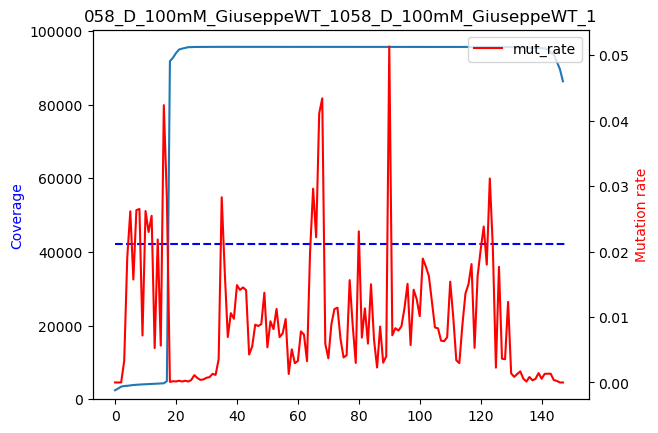

  8%|▊         | 1/12 [01:24<15:30, 84.55s/it]








Running rf-map for 058_D_100mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                      Type           File(s)

  058_D_100mM_GiuseppeWT_2    Single-read    058_D_100mM_GiuseppeWT_2

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_100mM_GiuseppeWT_2" (PID: 72583)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_100mM_GiuseppeWT_2" (PID: 72585)

[+] Mapping statistics:

  [*] Sample "058_D_100mM_GiuseppeWT_2" [Mapped: 5.03%; Failed: 75.39%; Multiple: 19.58%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_100mM_GiuseppeWT_2.bam" (PID: 72594)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                             File format    Sorted    Indexed    5'-end trimming

  058_D_100mM_GiuseppeWT_2_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_100mM_GiuseppeWT_2_sorted": 1 transcripts covered [A: 44.86; C: 25.82; G: 19.03; T: 10.29] - 534/910 (58.68%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_100mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter12

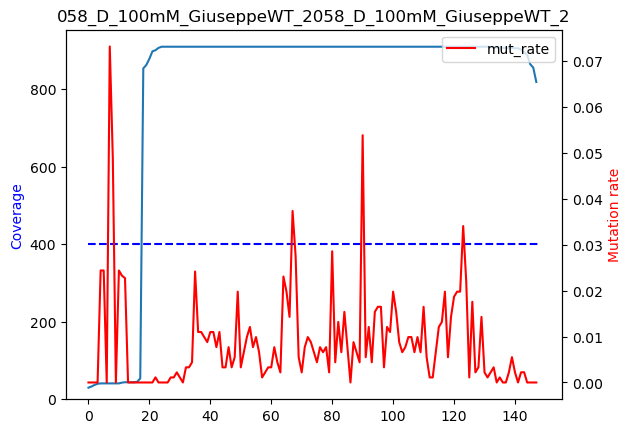

 17%|█▋        | 2/12 [01:28<06:09, 36.91s/it]








Running rf-map for 058_D_80mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_80mM_GiuseppeWT_2    Single-read    058_D_80mM_GiuseppeWT_2

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_80mM_GiuseppeWT_2" (PID: 72631)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_80mM_GiuseppeWT_2" (PID: 72633)

[+] Mapping statistics:

  [*] Sample "058_D_80mM_GiuseppeWT_2" [Mapped: 5.96%; Failed: 71.43%; Multiple: 22.61%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_80mM_GiuseppeWT_2.bam" (PID: 72637)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_80mM_GiuseppeWT_2_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_80mM_GiuseppeWT_2_sorted": 1 transcripts covered [A: 46.29; C: 25.87; G: 15.84; T: 12.00] - 452/804 (56.22%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_80mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125
Pl

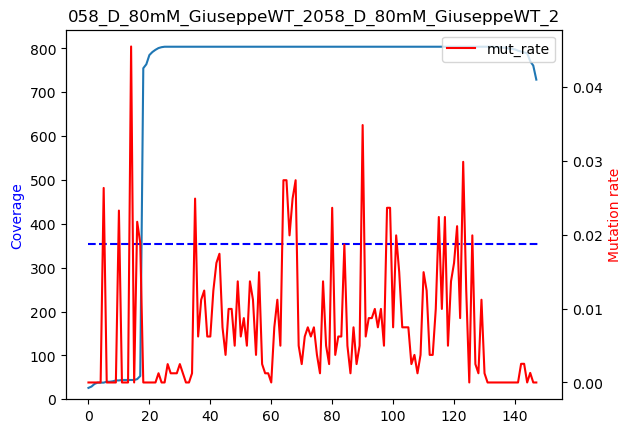

 25%|██▌       | 3/12 [01:31<03:13, 21.48s/it]








Running rf-map for 058_D_40mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_40mM_GiuseppeWT_1    Single-read    058_D_40mM_GiuseppeWT_1

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_40mM_GiuseppeWT_1" (PID: 72678)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_40mM_GiuseppeWT_1" (PID: 72680)

[+] Mapping statistics:

  [*] Sample "058_D_40mM_GiuseppeWT_1" [Mapped: 6.64%; Failed: 12.34%; Multiple: 81.02%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_40mM_GiuseppeWT_1.bam" (PID: 72688)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_40mM_GiuseppeWT_1_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_40mM_GiuseppeWT_1_sorted": 1 transcripts covered [A: 40.41; C: 24.96; G: 17.46; T: 17.17] - 40724/100016 (40.72%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_40mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter1

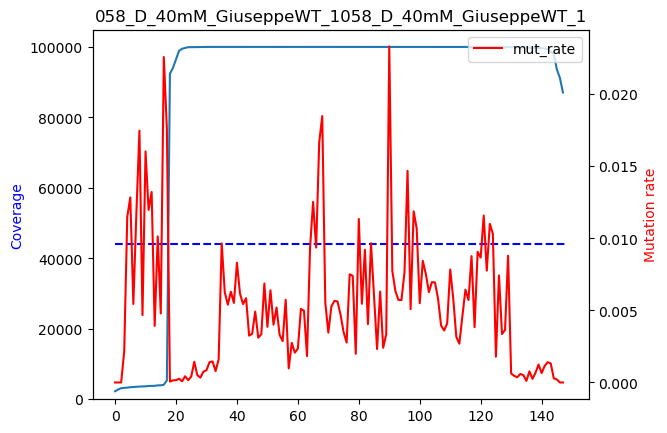

 33%|███▎      | 4/12 [03:04<06:39, 49.91s/it]








Running rf-map for 058_D_60mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_60mM_GiuseppeWT_1    Single-read    058_D_60mM_GiuseppeWT_1

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_60mM_GiuseppeWT_1" (PID: 72738)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_60mM_GiuseppeWT_1" (PID: 72740)

[+] Mapping statistics:

  [*] Sample "058_D_60mM_GiuseppeWT_1" [Mapped: 6.46%; Failed: 55.69%; Multiple: 37.85%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_60mM_GiuseppeWT_1.bam" (PID: 72752)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_60mM_GiuseppeWT_1_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_60mM_GiuseppeWT_1_sorted": 1 transcripts covered [A: 43.61; C: 27.16; G: 15.39; T: 13.85] - 8425/16616 (50.70%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_60mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125

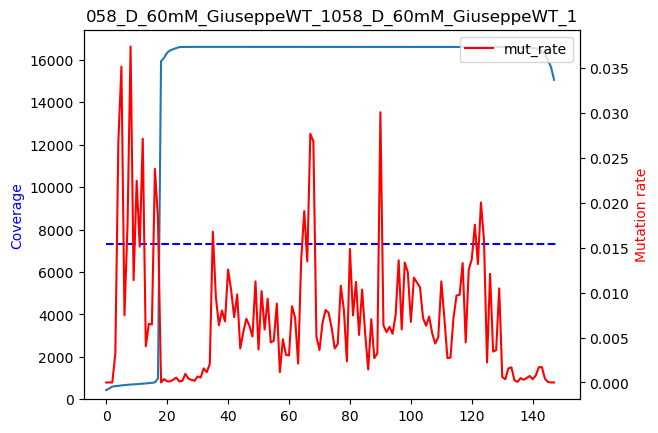

 42%|████▏     | 5/12 [03:28<04:44, 40.66s/it]








Running rf-map for 058_E_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                Type           File(s)

  058_E_GiuseppeWT_1    Single-read    058_E_GiuseppeWT_1

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_E_GiuseppeWT_1" (PID: 72793)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_E_GiuseppeWT_1" (PID: 72799)

[+] Mapping statistics:

  [*] Sample "058_E_GiuseppeWT_1" [Mapped: 4.45%; Failed: 3.66%; Multiple: 91.89%]

[+] Sorting BAM files...

  [-] Sorting sample "058_E_GiuseppeWT_1.bam" (PID: 72816)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                       File format    Sorted    Indexed    5'-end trimming

  058_E_GiuseppeWT_1_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_E_GiuseppeWT_1_sorted": 1 transcripts covered [A: 27.26; C: 17.13; G: 23.54; T: 32.08] - 35222/173015 (20.36%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_E_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125
Plotting rc for 0

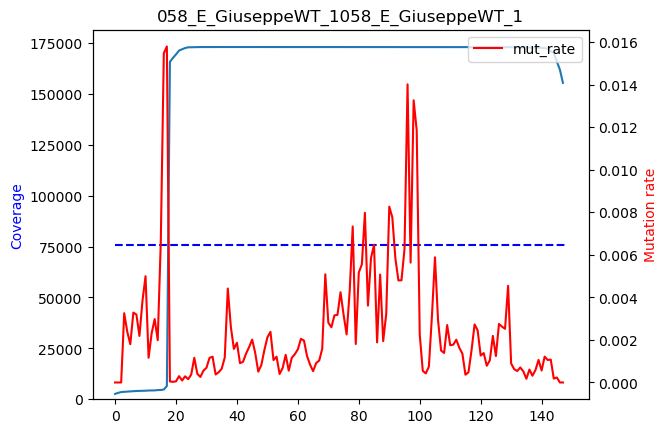

 50%|█████     | 6/12 [06:03<07:57, 79.53s/it]








Running rf-map for 058_D_20mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_20mM_GiuseppeWT_2    Single-read    058_D_20mM_GiuseppeWT_2

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_20mM_GiuseppeWT_2" (PID: 72891)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_20mM_GiuseppeWT_2" (PID: 72893)

[+] Mapping statistics:

  [*] Sample "058_D_20mM_GiuseppeWT_2" [Mapped: 3.52%; Failed: 80.50%; Multiple: 15.97%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_20mM_GiuseppeWT_2.bam" (PID: 72897)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_20mM_GiuseppeWT_2_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_20mM_GiuseppeWT_2_sorted": 1 transcripts covered [A: 35.45; C: 26.46; G: 17.99; T: 20.11] - 130/338 (38.46%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_20mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125
Pl

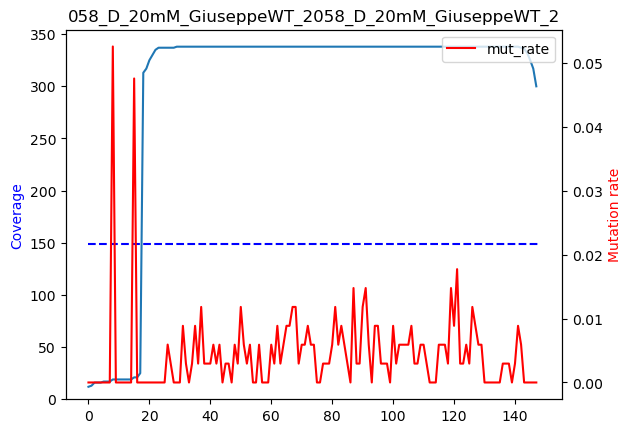

 58%|█████▊    | 7/12 [06:07<04:33, 54.80s/it]








Running rf-map for 058_D_40mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_40mM_GiuseppeWT_2    Single-read    058_D_40mM_GiuseppeWT_2

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_40mM_GiuseppeWT_2" (PID: 72934)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_40mM_GiuseppeWT_2" (PID: 72936)

[+] Mapping statistics:

  [*] Sample "058_D_40mM_GiuseppeWT_2" [Mapped: 5.82%; Failed: 67.14%; Multiple: 27.04%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_40mM_GiuseppeWT_2.bam" (PID: 72940)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_40mM_GiuseppeWT_2_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_40mM_GiuseppeWT_2_sorted": 1 transcripts covered [A: 43.82; C: 25.21; G: 15.30; T: 15.67] - 519/1229 (42.23%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_40mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125
P

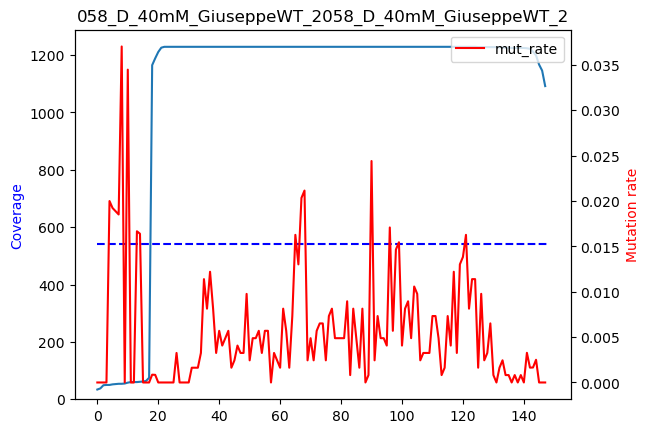

 67%|██████▋   | 8/12 [06:14<02:37, 39.40s/it]








Running rf-map for 058_D_80mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_80mM_GiuseppeWT_1    Single-read    058_D_80mM_GiuseppeWT_1

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_80mM_GiuseppeWT_1" (PID: 72977)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_80mM_GiuseppeWT_1" (PID: 72983)

[+] Mapping statistics:

  [*] Sample "058_D_80mM_GiuseppeWT_1" [Mapped: 8.84%; Failed: 3.97%; Multiple: 87.19%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_80mM_GiuseppeWT_1.bam" (PID: 73094)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_80mM_GiuseppeWT_1_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_80mM_GiuseppeWT_1_sorted": 1 transcripts covered [A: 45.64; C: 25.63; G: 16.51; T: 12.22] - 92095/158967 (57.93%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_80mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter1

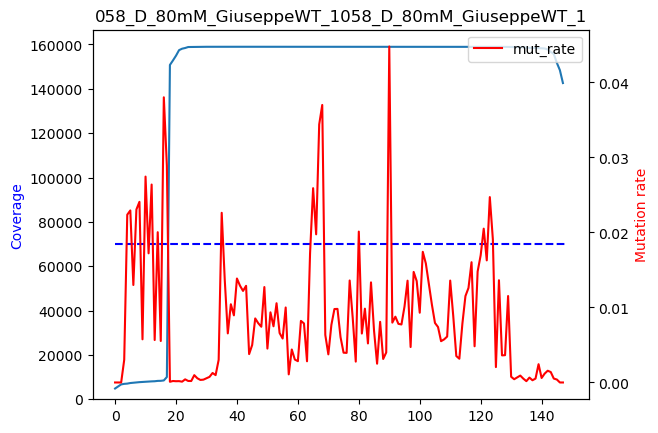

 75%|███████▌  | 9/12 [15:06<09:40, 193.61s/it]








Running rf-map for 058_E_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                Type           File(s)

  058_E_GiuseppeWT_2    Single-read    058_E_GiuseppeWT_2

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_E_GiuseppeWT_2" (PID: 73217)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_E_GiuseppeWT_2" (PID: 73219)

[+] Mapping statistics:

  [*] Sample "058_E_GiuseppeWT_2" [Mapped: 4.32%; Failed: 59.46%; Multiple: 36.21%]

[+] Sorting BAM files...

  [-] Sorting sample "058_E_GiuseppeWT_2.bam" (PID: 73231)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                       File format    Sorted    Indexed    5'-end trimming

  058_E_GiuseppeWT_2_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_E_GiuseppeWT_2_sorted": 1 transcripts covered [A: 28.38; C: 18.37; G: 22.42; T: 30.83] - 4330/19792 (21.88%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_E_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125
Plotting rc for 058

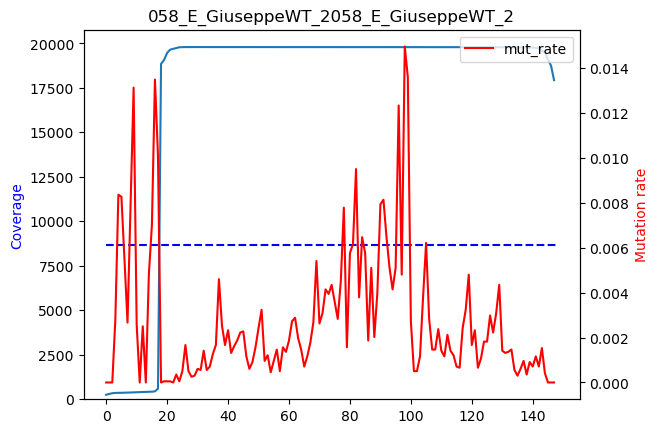

 83%|████████▎ | 10/12 [15:33<04:44, 142.02s/it]








Running rf-map for 058_D_60mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_60mM_GiuseppeWT_2    Single-read    058_D_60mM_GiuseppeWT_2

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_60mM_GiuseppeWT_2" (PID: 73276)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_60mM_GiuseppeWT_2" (PID: 73278)

[+] Mapping statistics:

  [*] Sample "058_D_60mM_GiuseppeWT_2" [Mapped: 5.17%; Failed: 68.76%; Multiple: 26.07%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_60mM_GiuseppeWT_2.bam" (PID: 73287)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_60mM_GiuseppeWT_2_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_60mM_GiuseppeWT_2_sorted": 1 transcripts covered [A: 42.70; C: 25.17; G: 17.27; T: 14.86] - 3363/7140 (47.10%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_60mM_GiuseppeWT_2.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125


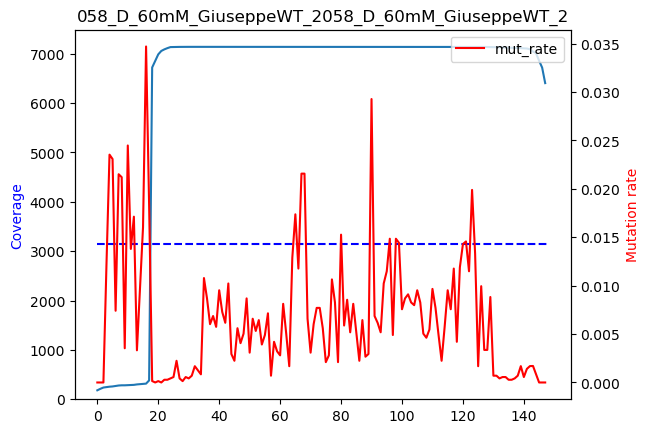

 92%|█████████▏| 11/12 [15:46<01:42, 102.62s/it]








Running rf-map for 058_D_20mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results will be saved in rf_map_filter125



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Validating FastQ files:

  Sample                     Type           File(s)

  058_D_20mM_GiuseppeWT_1    Single-read    058_D_20mM_GiuseppeWT_1

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "058_D_20mM_GiuseppeWT_1" (PID: 73328)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "058_D_20mM_GiuseppeWT_1" (PID: 73330)

[+] Mapping statistics:

  [*] Sample "058_D_20mM_GiuseppeWT_1" [Mapped: 3.40%; Failed: 80.64%; Multiple: 15.96%]

[+] Sorting BAM files...

  [-] Sorting sample "058_D_20mM_GiuseppeWT_1.bam" (PID: 73334)

[+] All done.

Sorting and indexing the BAM file



  [i] Note: An update to RNA Framework is available. Please issue a 'git pull'.



[+] Making output directory...
[+] Checking files:

  Sample                            File format    Sorted    Indexed    5'-end trimming

  058_D_20mM_GiuseppeWT_1_sorted    BAM            Yes       Yes        Ignored

[+] Getting transcripts from reference, and building count table base structure...
[+] Inspecting SAM/BAM file headers...

[+] Copying RC base structure...
[+] Queuing jobs...
[+] Calculating per-base mutation counts and coverage. This may take a while...

|██████████████████████████████████████████████████| (Done: 100.00%)

[+] Re-assembling partial MM files...
[+] Indexing MM files...
[+] Statistics:

  [*] Sample "058_D_20mM_GiuseppeWT_1_sorted": 1 transcripts covered [A: 36.76; C: 19.12; G: 21.08; T: 23.04] - 126/389 (32.39%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for 058_D_20mM_GiuseppeWT_1.fastq, reference /Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa. Results are saved in rf_count_filter125
Pl

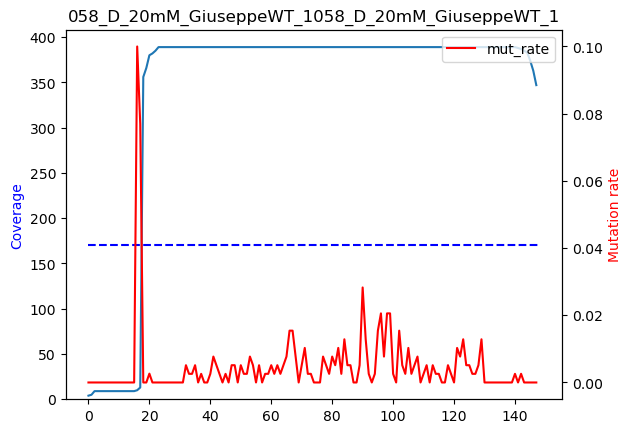

100%|██████████| 12/12 [15:49<00:00, 79.10s/it] 

In [8]:
# run analysis
from tqdm import tqdm

all_fastq_names = [f.removesuffix(".fastq") for f in os.listdir(f'{Working_dir}/fastq') if f.endswith('.fastq')]
for fastq_name in tqdm(all_fastq_names):
    try:
        map_and_count('/Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa', f"{fastq_name}.fastq", overwrite=True, output_prefix='filter125', plot_results=True)
    except Exception as e:
        print(f"Error with {fastq_name}: {e}")
        continue

# Results

They use only the first 171 bases of the cspA UTR, should select this region. Even so, coverage is a bit strange. Maybe some quality trimming is needed?

In [5]:
# plot mutation rate and coverages for all SRRs
import tqdm as tqdm
for fastq_name in tqdm(all_fastq_names):
    try:
        plot_rc(fastq_name, output_prefix='draco_params')
    except Exception as e:
        print(f"\n\nError in {fastq_name}: {e}\n\n")
        continue

NameError: name 'all_fastq_names' is not defined

In [6]:
# coverage is a bit sus... let's run fastqc and see the results
def run_fastqc(fastq_name, overwrite = False):
    '''Run fastqc on the fastq file'''
    path_to_fastq = f"{Working_dir}/fastq/{fastq_name}.fastq"
    if not overwrite:
        if os.path.exists(path_to_fastq.replace('.fastq', '_fastqc.html')):
            print(f"{fastq_name}.fastq already exists. Skipping")
            return
    os.chdir(f"{Working_dir}/fastq")
    cmd = f"fastqc {fastq_name}.fastq"
    subprocess.run(cmd, shell=True, check=True)
    os.chdir(f"{Working_dir}/fastq")
    print(f"fastqc completed for {fastq_name}")

import tqdm as tqdm
for fastq_name in tqdm(all_fastq_names):
    try:
        run_fastqc(fastq_name)
    except Exception as e:
        print(f"\n\nError in {fastq_name}: {e}\n\n")
        continue

NameError: name 'all_fastq_names' is not defined

In [9]:
import re
import uuid
import os

# create file with information on experiments
ref_fasta = '/Users/giuseppesacco/uni/unified-rna-struct/Newseq/reference.fa'
output_suffix = 'draco_params'
output_suffix = 'filter125'

# example: $RNA_STRUCT_HOME/Newseq/RNAf_results/058_D_100mM_GiuseppeWT_2/rf_map_draco_params/rf_count/058_D_100mM_GiuseppeWT_2_sorted.rc
all_fastq_names = [f.removesuffix(".fastq") for f in os.listdir(f'{Working_dir}/fastq') if f.endswith('.fastq')]
paths_to_rc = [
    f"$RNA_STRUCT_HOME/Newseq/RNAf_results/{fastq_name}/rf_map_{output_suffix}/rf_count/{fastq_name}_sorted.rc"
    for fastq_name in all_fastq_names
]
#paths_to_rc = [p.replace('$RNA_STRUCT_HOME', os.getenv('RNA_STRUCT_HOME')) for p in paths_to_rc]
#for paths in paths_to_rc:
#    assert os.path.exists(paths.replace('$RNA_STRUCT_HOME', os.getenv('RNA_STRUCT_HOME'))), f"File {paths} does not exist"
newfiles_paths = [
    rc.removesuffix('.rc') + '.txt'
    for rc in paths_to_rc
]
newfiles_paths = [p.replace('$RNA_STRUCT_HOME', os.getenv('RNA_STRUCT_HOME')) for p in newfiles_paths]
def parse_meta_from_name(name: str):
    # replicate = trailing _<digits>
    rep_match = re.search(r'_(\d+)$', name)
    rep = int(rep_match.group(1)) if rep_match else None
    if rep is None:
        raise ValueError("No replicate number found")
    # concentration = token like 123mM anywhere in the name
    conc_match = re.search(r'(\d+)mM', name)
    conc = int(conc_match.group(1)) if conc_match else 0
    # control if no conc in name (e.g., 058_E_GiuseppeWT_<rep>)
    return conc, rep

for rc, txt in zip(paths_to_rc, newfiles_paths):
    fastq_name = rc.split('/')[-4]  # folder name is the fastq base name
    conc_mM, rep_number = parse_meta_from_name(fastq_name)
    # Build descriptions
    description = f"NewseqWT conc {conc_mM}mM rep {rep_number}"
    short_description = f"WT {conc_mM}mM r{rep_number}"
    conc_field = str(conc_mM)

    os.makedirs(os.path.dirname(txt), exist_ok=True)
    with open(txt, 'w') as f:
        f.write("### Chemical probing experiment\n")
        unique_id = uuid.uuid4()
        f.write(f"ID:\t{unique_id}\n")
        f.write(f"Description:\t{description}\n")
        f.write(f"Short description:\t{short_description}\n")
        f.write(f"Path to rc data:\t{rc}\n")
        f.write("Reagent:\tDMS\n")
        f.write(f"Concentration:\t{conc_field}\n")
        f.write(f"SRR:\t{fastq_name}\n")
        f.write(f"Path to full reference fasta:\t{ref_fasta}\n")
        f.write("Temperature:\t37\n")
        f.write("system:\tNewseqWT\n")
        try:
            rep_out = int(rep_number) if rep_number is not None else 1
        except ValueError:
            rep_out = 1
        f.write(f"Rep number:\t{rep_out}\n")
    print(f"File {txt} created")
   

File /Users/giuseppesacco/uni/unified-rna-struct/Newseq/RNAf_results/058_D_100mM_GiuseppeWT_1/rf_map_filter125/rf_count/058_D_100mM_GiuseppeWT_1_sorted.txt created
File /Users/giuseppesacco/uni/unified-rna-struct/Newseq/RNAf_results/058_D_100mM_GiuseppeWT_2/rf_map_filter125/rf_count/058_D_100mM_GiuseppeWT_2_sorted.txt created
File /Users/giuseppesacco/uni/unified-rna-struct/Newseq/RNAf_results/058_D_80mM_GiuseppeWT_2/rf_map_filter125/rf_count/058_D_80mM_GiuseppeWT_2_sorted.txt created
File /Users/giuseppesacco/uni/unified-rna-struct/Newseq/RNAf_results/058_D_40mM_GiuseppeWT_1/rf_map_filter125/rf_count/058_D_40mM_GiuseppeWT_1_sorted.txt created
File /Users/giuseppesacco/uni/unified-rna-struct/Newseq/RNAf_results/058_D_60mM_GiuseppeWT_1/rf_map_filter125/rf_count/058_D_60mM_GiuseppeWT_1_sorted.txt created
File /Users/giuseppesacco/uni/unified-rna-struct/Newseq/RNAf_results/058_E_GiuseppeWT_1/rf_map_filter125/rf_count/058_E_GiuseppeWT_1_sorted.txt created
File /Users/giuseppesacco/uni/unif

In [9]:
 
# Redmond's data
# create file with information on experiments
ref_fasta = "None"
systems = ['HCV_IRES', 'bact_RNaseP_typeA', 'V_chol_gly_riboswitch', 'tetrahymena_ribozyme', 'hc16']
#ex: RedmondData/ivt_2/Rep1_0mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.rc
rps_num = [1,2]
concs = [0,8,17,34,57,85]
for system in systems:
    for rep_num in rps_num:
        for conc in concs:
            txt = f"{RNA_STRUCT_HOME}/RedmondData/ivt_2/Rep{rep_num}_{conc}mM/{system}/rfcount_ndni/LAST_MD_sorted.txt"
            rc = f"$RNA_STRUCT_HOME/RedmondData/ivt_2/Rep{rep_num}_{conc}mM/{system}/rfcount_ndni/LAST_MD_sorted.rc"
            assert os.path.exists(os.path.expandvars(rc)), f"File {rc} does not exist"
            with open(txt, 'w') as f:
                f.write(f"### Chemical probing experiment\n")
                # create a unique ID for the experiment
                unique_id = uuid.uuid4()
                f.write(f"ID:\t{unique_id}\n")
                f.write(f"Description:\t{system} {conc}mM r{rep_num}\n")
                f.write(f"Short description:\t{system} {conc}mM r{rep_num}\n")
                f.write(f"Path to rc data:\t{rc}\n")
                f.write(f"Reagent:\tDMS\n")
                f.write(f"Concentration:\t{conc}\n")
                f.write(f"SRR:\tNone\n")
                f.write(f"Path to full reference fasta:\tNone\n")
                temp = 37
                f.write(f"Temperature:\t{temp}\n")
                f.write(f"system:\t{system}\n")
                f.write(f"Rep number:\t{rep_num}\n")
            print(f"File {txt} created")

File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep1_0mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep1_8mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep1_17mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep1_34mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep1_57mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep1_85mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep2_0mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/Rep2_8mM/HCV_IRES/rfcount_ndni/LAST_MD_sorted.txt created
File /Users/giuseppesacco/uni/rna_struct/RedmondData/ivt_2/R

## Reads
We are not using the reads for now, but we may in the future.

[rf-mmtools](https://rnaframework-docs.readthedocs.io/en/latest/rf-mmtools/) enables visualization/manipulation of mutation map files.
The view command produces an output structured as below in which, for each transcript, the first two rows correspond to the transcript's ID and sequence, followed by the reads, one per row. Each read row contains:
- Start mapping position (0-based)
- End mapping position (0-based)
- Comma-separated list of indexes (0-based) of mutated bases (with respect to transcript's start)
Consecutive entries are separated by a newline.

In [ ]:
# open mm file
fastq_name = "SRR6507969"
output_prefix = ""
os.chdir(f"/u/g/gsacco/work/rna_struct/data_validation_draco/{fastq_name}/rf_map_{output_prefix}/rf_count/")
mm_file = f"{fastq_name}_sorted.mm"
# use rf-mmtools to visualize the the first few rows of the mm file
cmd = f"rf-mmtools view {mm_file} | head"
subprocess.run(cmd, shell=True, check=True)


NC_000913.3_3719716-3720292
TGATGCGTTTGATTCAAGCCAACCCGGCATTAAGTAAGCAGTTGATGGAATAGACTTTTATCCACTTTATTGCTGTTTACGGTCCTGATGACAGGACCGTTTTCCAACCGATTAATCATAAATATGAAAAATAATTGTTGCATCACCCGCCAATGCGTGGCTTAATGCACATCAACGGTTTGACGTACAGACCATTAAAGCAGTGTAGTAAGGCAAGTCCCTTCAAGAGTTATCGTTGATACCCCTCGTAGTGCACATTCCTTTAACGCTTCAAAATCTGTAAAGCACGCCATATCGCCGAAAGGCACACTTAATTATTAAAGGTAATACACTATGTCCGGTAAAATGACTGGTATCGTAAAATGGTTCAACGCTGACAAAGGCTTCGGCTTCATCACTCCTGACGATGGCTCTAAAGATGTGTTCGTACACTTCTCTGCTATCCAGAACGATGGTTACAAATCTCTGGACGAAGGTCAGAAAGTGTCCTTCACCATCGAAAGCGGCGCTAAAGGCCCGGCAGCTGGTAACGTAACCAGCCTGTAATCTCTGCTTAAAAGCACAGAATCTAAGATCC
169	272	172,225,233,238
169	272	172,225,233,238
170	272	173,209,224,238,243,255,265
170	223	173,197,206
170	272	173,197,206
170	272	173,224,255
170	266	173,214,218
170	272	173


CompletedProcess(args='rf-mmtools view SRR6507969_sorted.mm | head', returncode=0)

In [7]:
# run analysis
from tqdm import tqdm
all_cspA_SRR = ['SRR6123773', 'SRR6123774', 'SRR6123775', 'SRR6507966','SRR6507967','SRR6507968', 'SRR6507969']
for SRR in tqdm(all_cspA_SRR):
    try:
        map_and_count("cspA_171_nt.fa", f"{SRR}.fastq", overwrite=False, output_prefix='draco_params_170_nt', plot_results=True)
    except Exception as e:
        print(f"Error with {SRR}: {e}")
        continue

  0%|          | 0/7 [00:00<?, ?it/s]



Running rf-map for SRR6123773.fastq, reference cspA_171_nt.fa. Results will be saved in rf_map_draco_params_170_nt




  [!] Error: Output directory already exists.
      Please use -ow (or --overwrite) to overwrite output directory

 14%|█▍        | 1/7 [00:03<00:19,  3.21s/it]


[+] Making output directory...Error with SRR6123773: Command 'rf-map -cq5 20 -cqo -mp '--very-sensitive-local' -b2 -bi ../cspA_171_nt.fa_index -o rf_map_draco_params_170_nt SRR6123773.fastq' returned non-zero exit status 2.


Running rf-map for SRR6123774.fastq, reference cspA_171_nt.fa. Results will be saved in rf_map_draco_params_170_nt




  [!] Error: Output directory already exists.
      Please use -ow (or --overwrite) to overwrite output directory

 29%|██▊       | 2/7 [00:05<00:13,  2.67s/it]


[+] Making output directory...Error with SRR6123774: Command 'rf-map -cq5 20 -cqo -mp '--very-sensitive-local' -b2 -bi ../cspA_171_nt.fa_index -o rf_map_draco_params_170_nt SRR6123774.fastq' returned non-zero exit status 2.


Running rf-map for SRR6123775.fastq, reference cspA_171_nt.fa. Results will be saved in rf_map_draco_params_170_nt

[+] Making output directory...
[+] Validating FastQ files:

  Sample        Type           File(s)

  SRR6123775    Single-read    SRR6123775

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "SRR6123775" (PID: 12964)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "SRR6123775" (PID: 13013)

[+] Mapping statistics:

  [*] Sample "SRR6123775" [Mapped: 1.14%; Failed: 98.85%; Multiple: 0.01%]

[+] Sorting BAM files...

  [-] Sorting sample "SRR6123775.bam" (PID: 13324)

[+] All done.

Sorting and indexing the BAM file

[+] Making output directory...
[+] Checkin

 43%|████▎     | 3/7 [06:45<12:16, 184.22s/it]


[+] Statistics:

  [*] Sample "SRR6123775_sorted": 1 transcripts covered [A: 61.34; C: 31.84; G: 3.93; T: 2.89] - 33279/36995 (89.96%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for SRR6123775.fastq, reference cspA_171_nt.fa. Results are saved in rf_count_draco_params_170_nt
Error with SRR6123775: [Errno 2] No such file or directory: 'data_validation_draco/SRR6123775/rf_map_draco_params_170_nt/rf_count/SRR6123775_sorted.rc'


Running rf-map for SRR6507966.fastq, reference cspA_171_nt.fa. Results will be saved in rf_map_draco_params_170_nt

[+] Making output directory...
[+] Validating FastQ files:

  Sample        Type           File(s)

  SRR6507966    Single-read    SRR6507966

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "SRR6507966" (PID: 13397)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "SRR6507966" (PID: 13410)

[+] Mapping statistic

 57%|█████▋    | 4/7 [12:09<11:58, 239.38s/it]


[+] Statistics:

  [*] Sample "SRR6507966_sorted": 1 transcripts covered [A: 60.86; C: 30.88; G: 4.61; T: 3.64] - 112757/174928 (64.46%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for SRR6507966.fastq, reference cspA_171_nt.fa. Results are saved in rf_count_draco_params_170_nt
Error with SRR6507966: [Errno 2] No such file or directory: 'data_validation_draco/SRR6507966/rf_map_draco_params_170_nt/rf_count/SRR6507966_sorted.rc'


Running rf-map for SRR6507967.fastq, reference cspA_171_nt.fa. Results will be saved in rf_map_draco_params_170_nt

[+] Making output directory...
[+] Validating FastQ files:

  Sample        Type           File(s)

  SRR6507967    Single-read    SRR6507967

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "SRR6507967" (PID: 14140)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "SRR6507967" (PID: 14150)

[+] Mapping statist

 71%|███████▏  | 5/7 [17:18<08:48, 264.42s/it]


[+] Statistics:

  [*] Sample "SRR6507967_sorted": 1 transcripts covered [A: 62.89; C: 31.46; G: 3.29; T: 2.35] - 140064/168302 (83.22%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for SRR6507967.fastq, reference cspA_171_nt.fa. Results are saved in rf_count_draco_params_170_nt
Error with SRR6507967: [Errno 2] No such file or directory: 'data_validation_draco/SRR6507967/rf_map_draco_params_170_nt/rf_count/SRR6507967_sorted.rc'


Running rf-map for SRR6507968.fastq, reference cspA_171_nt.fa. Results will be saved in rf_map_draco_params_170_nt

[+] Making output directory...
[+] Validating FastQ files:

  Sample        Type           File(s)

  SRR6507968    Single-read    SRR6507968

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "SRR6507968" (PID: 14477)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "SRR6507968" (PID: 14489)

[+] Mapping statist

 86%|████████▌ | 6/7 [21:35<04:21, 261.99s/it]


[+] Statistics:

  [*] Sample "SRR6507968_sorted": 1 transcripts covered [A: 62.74; C: 31.35; G: 3.63; T: 2.28] - 128303/146552 (87.55%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for SRR6507968.fastq, reference cspA_171_nt.fa. Results are saved in rf_count_draco_params_170_nt
Error with SRR6507968: [Errno 2] No such file or directory: 'data_validation_draco/SRR6507968/rf_map_draco_params_170_nt/rf_count/SRR6507968_sorted.rc'


Running rf-map for SRR6507969.fastq, reference cspA_171_nt.fa. Results will be saved in rf_map_draco_params_170_nt

[+] Making output directory...
[+] Validating FastQ files:

  Sample        Type           File(s)

  SRR6507969    Single-read    SRR6507969

[+] Processing FastQ files...
[+] Clipping adapter sequences/low quality bases from sequencing reads...

  [-] Processing sample "SRR6507969" (PID: 14745)

[+] Mapping reads to transcriptome...

  [-] Mapping sample "SRR6507969" (PID: 14757)

[+] Mapping statist

100%|██████████| 7/7 [26:15<00:00, 225.03s/it]


[+] Statistics:

  [*] Sample "SRR6507969_sorted": 1 transcripts covered [A: 57.42; C: 36.37; G: 3.83; T: 2.39] - 133134/156304 (85.18%) mutated alignments

[+] Cleaning up temporary files...
[+] All done.

rf-count completed for SRR6507969.fastq, reference cspA_171_nt.fa. Results are saved in rf_count_draco_params_170_nt
Error with SRR6507969: [Errno 2] No such file or directory: 'data_validation_draco/SRR6507969/rf_map_draco_params_170_nt/rf_count/SRR6507969_sorted.rc'


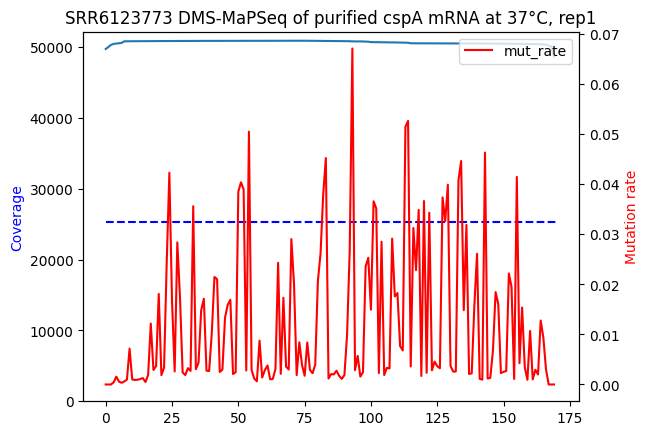

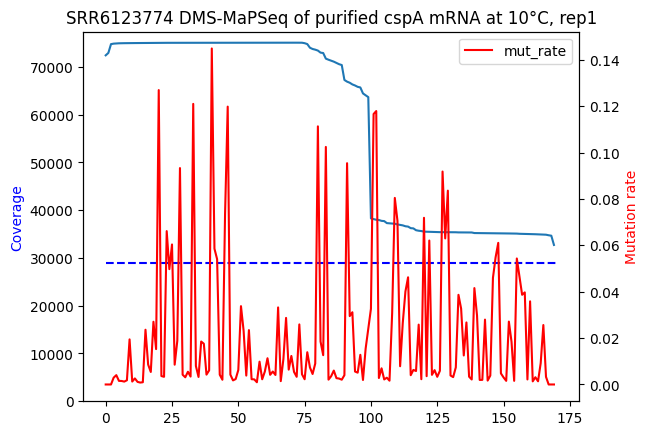

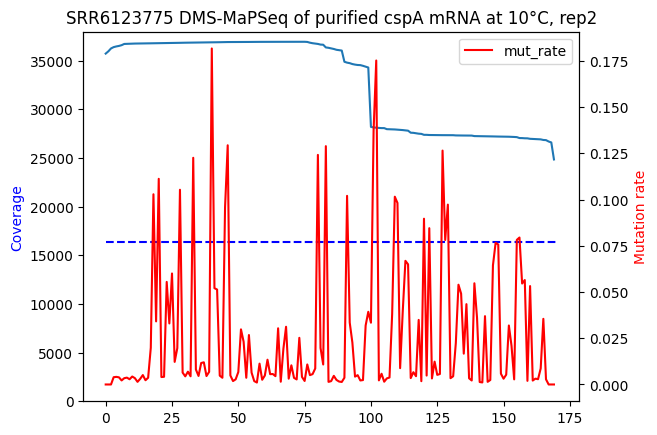

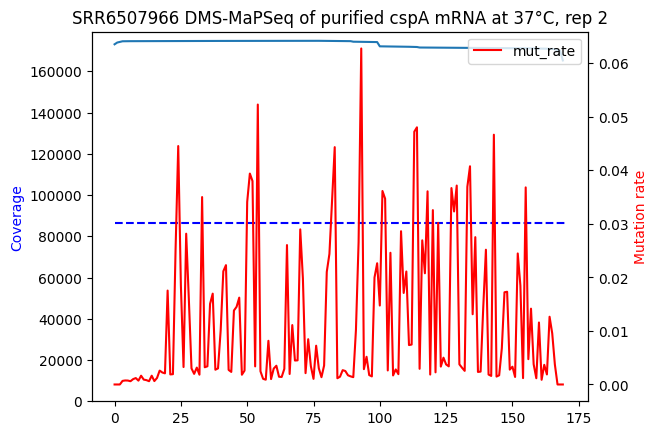

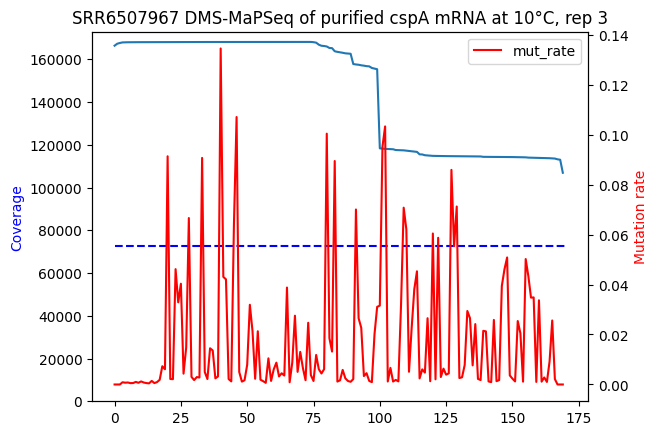

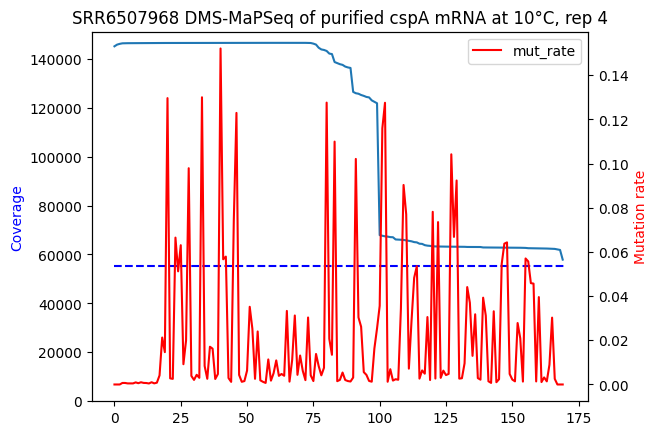

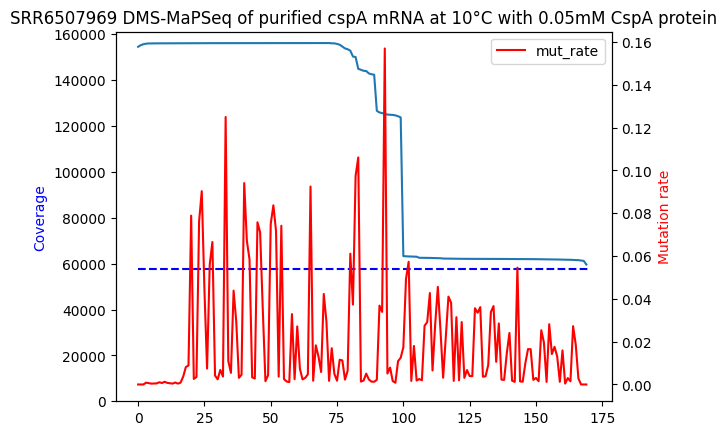

In [19]:
# plot mutation rate and coverages for all SRRs
for SRR in all_cspA_SRR:
    os.chdir(f"/u/g/gsacco/work/rna_struct")
    try:
        plot_rc(SRR, output_prefix='draco_params_170_nt')
    except Exception as e:
        print(f"\n\nError in {SRR}: {e}\n\n")
        continue

# Analysis of V. vulnificus add riboswitch DMS-MaPseq data.
From DRACO:
> DMS-MaPseq data for the add riboswitch from V. vulnificus, in vitro folded either in the presence or absence of 5 mM adenine, were obtained from the Sequence Read Archive (accessions, SRR10850890 and SRR10850891). Forward and reverse reads were merged, prior to mapping, using PEAR (Illumina paired-end read merger) v0.9.11 (ref. 16), and then mapped to the add riboswitch using the rf-map tool (parameters: -cq5 20 -cqo -ctn -cmn 0 --mp ‘--very-sensitive-local’). Resulting BAM files were then analyzed with the rf-count tool to produce[...]

Note that the parameters are slightly different to the cspA ones.

In [1]:
import subprocess
import os
RNA_STRUCT_HOME = os.environ.get('RNA_STRUCT_HOME')

In [ ]:
# open mm file
import os
fastq_name = "SRR6507969"
output_prefix = ""
os.chdir(f"{RNA_STRUCT_HOME}/data_validation_draco/{fastq_name}/rf_map_{output_prefix}/rf_count/")
mm_file = f"{fastq_name}_sorted.mm"
# use rf-mmtools to visualize the mutations
cmd = f"rf-mmtools view {mm_file}"
subprocess.run(cmd, shell=True, check=True)

NC_000913.3_3719716-3720292
TGATGCGTTTGATTCAAGCCAACCCGGCATTAAGTAAGCAGTTGATGGAATAGACTTTTATCCACTTTATTGCTGTTTACGGTCCTGATGACAGGACCGTTTTCCAACCGATTAATCATAAATATGAAAAATAATTGTTGCATCACCCGCCAATGCGTGGCTTAATGCACATCAACGGTTTGACGTACAGACCATTAAAGCAGTGTAGTAAGGCAAGTCCCTTCAAGAGTTATCGTTGATACCCCTCGTAGTGCACATTCCTTTAACGCTTCAAAATCTGTAAAGCACGCCATATCGCCGAAAGGCACACTTAATTATTAAAGGTAATACACTATGTCCGGTAAAATGACTGGTATCGTAAAATGGTTCAACGCTGACAAAGGCTTCGGCTTCATCACTCCTGACGATGGCTCTAAAGATGTGTTCGTACACTTCTCTGCTATCCAGAACGATGGTTACAAATCTCTGGACGAAGGTCAGAAAGTGTCCTTCACCATCGAAAGCGGCGCTAAAGGCCCGGCAGCTGGTAACGTAACCAGCCTGTAATCTCTGCTTAAAAGCACAGAATCTAAGATCC
169	272	172,225,233,238
169	272	172,225,233,238
170	272	173,209,224,238,243,255,265
170	223	173,197,206
170	272	173,197,206
170	272	173,224,255
170	266	173,214,218
170	272	173
170	272	173,197,206,233
170	245	173,214,218,238
170	272	173
170	272	173,193,198,223,266
170	245	173,213
170	224	173
170	242	173
170	272	173,201,213
170	412	173,220,255,266,273,307,343,345,361,380
170	272	173,213,218,26

CompletedProcess(args='rf-mmtools view SRR6507969_sorted.mm', returncode=0)

In [3]:

cmd = f"rf-mmtools stats {mm_file}"
subprocess.run(cmd, shell=True, check=True)

Read length    # of reads    %

36             54            0.03
37             83            0.04
38             112           0.06
39             123           0.06
40             238           0.12
41             1149          0.60
42             139           0.07
43             110           0.06
44             149           0.08
45             299           0.16
46             138           0.07
47             129           0.07
48             294           0.15
49             350           0.18
50             643           0.34
51             366           0.19
52             12567         6.55
53             188           0.10
54             263           0.14
55             224           0.12
56             262           0.14
57             115           0.06
58             431           0.22
59             164           0.09
60             322           0.17
61             346           0.18
62             206           0.11
63             396           0.21
64             4

CompletedProcess(args='rf-mmtools stats SRR6507969_sorted.mm', returncode=0)